In [2]:
"""
Get the general graph of a given model

Algorithm :
Get model & dicts
Get circuit fct
aggregate graphs over dataset
test this graph on dataset

TODO : get circuit fct is wrong from marks
TODO : test graph is wrong from marks (but eh, it will yield better results as we will
       have essentially the whole graph, but hush, don't say it ! :o)
"""

try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/feature-circuits
    %pip install -r requirements.txt
    !git submodule update --init
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os
import gc
import pickle
import math
import importlib


from transformers import logging
logging.set_verbosity_error()

import torch
from nnsight import LanguageModel
from datasets import load_dataset

import plotly.graph_objects as go
from scipy import interpolate

import networkx as nx

from dictionary_learning import AutoEncoder
from utils import SparseAct
from buffer import TokenBuffer
import evaluation
from circuit import get_circuit, save_circuit, load_circuit
from ablation import run_with_ablations

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("DEVICE :", DEVICE)

print("IN_COLAB :", IN_COLAB)

C:\Users\Grégoire\AppData\Roaming\Python\Python310\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


DEVICE : cpu
IN_COLAB : False


_____
# First step :
### generate the graph
_____

compute the circuit for random examples from wikipedia, and aggregate the results using your favorite aggregation method.

In [ ]:
def load_model_and_modules():    
    pythia70m = LanguageModel(
    "EleutherAI/pythia-70m-deduped",
    device_map=DEVICE,
    dispatch=True,
    )

    pythia70m_embed = pythia70m.gpt_neox.embed_in

    pythia70m_resids= []
    pythia70m_attns = []
    pythia70m_mlps = []
    for layer in range(len(pythia70m.gpt_neox.layers)):
        pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
        pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
        pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)

    submod_names = {
        pythia70m.gpt_neox.embed_in : 'embed'
    }
    for i in range(len(pythia70m.gpt_neox.layers)):
        submod_names[pythia70m.gpt_neox.layers[i].attention] = f'attn_{i}'
        submod_names[pythia70m.gpt_neox.layers[i].mlp] = f'mlp_{i}'
        submod_names[pythia70m.gpt_neox.layers[i]] = f'resid_{i}'

    return pythia70m, pythia70m_embed, pythia70m_resids, pythia70m_attns, pythia70m_mlps, submod_names

In [ ]:
def load_saes(
    model,
    model_embed,
    model_resids,
    model_attns,
    model_mlps,
):
    dictionaries = {}

    d_model = 512
    dict_size = 32768
    
    if IN_COLAB:
        base = "/content/gdrive/MyDrive/feature-circuits/"
    else:
        #base = "C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits/"
        base = 'C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/'
    path = base + "dictionary_learning/dictionaires/pythia-70m-deduped/"

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"embed/ae.pt", map_location=DEVICE))
    dictionaries[model_embed] = ae


    for layer in range(len(model.gpt_neox.layers)):
        ae = AutoEncoder(d_model, dict_size).to(DEVICE)
        ae.load_state_dict(torch.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
        dictionaries[model_resids[layer]] = ae

        ae = AutoEncoder(d_model, dict_size).to(DEVICE)
        ae.load_state_dict(torch.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
        dictionaries[model_attns[layer]] = ae

        ae = AutoEncoder(d_model, dict_size).to(DEVICE)
        ae.load_state_dict(torch.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
        dictionaries[model_mlps[layer]] = ae
    
    return dictionaries

TODO : is this batch size ok for generating the graph ?

In [ ]:
def get_buffer(
    model
):
    raise NotImplementedError("Check that this batch size is correct for all applications. Otherwize, put it as argument")
    dataset = load_dataset(
        "wikipedia",
        language="en",
        date="20240401",
        split="train",
        streaming=True,
        trust_remote_code=True
    ).shuffle()
    dataset = iter(dataset)

    buffer = TokenBuffer(
        dataset,
        model,
        n_ctxs=10,
        ctx_len=16,
        load_buffer_batch_size=10,
        return_batch_size=10,
        device=DEVICE,
        max_number_of_yields=2**20,
        discard_bos=True
    )

    return buffer

In [ ]:
def run_first_step():
        
    def metric_fn(model, trg=None):
        """
        default : return the logit
        """
        if trg is None:
            raise ValueError("trg must be provided")
        return model.embed_out.output[torch.arange(trg[0].numel()), trg[0], trg[1]]
    
    pythia70m, pythia70m_embed, pythia70m_resids, pythia70m_attns, pythia70m_mlps, submod_names = load_model_and_modules()

    dictionaries = load_saes(
        pythia70m,
        pythia70m_embed,
        pythia70m_resids,
        pythia70m_attns,
        pythia70m_mlps,
    )

    buffer = get_buffer(pythia70m)
    
    tot_circuit = None
    
    i = 0
    max_loop = -1
    edge_threshold = 0.01
    node_threshold = 0.1

    for tokens, trg_idx, trg in tqdm(buffer):
        if i >= max_loop:
            break
        i += 1
        circuit = get_circuit(
            tokens,
            None,
            model=pythia70m,
            embed=pythia70m_embed,
            attns=pythia70m_attns,
            mlps=pythia70m_mlps,
            resids=pythia70m_resids,
            dictionaries=dictionaries,
            metric_fn=metric_fn,
            metric_kwargs={"trg": (trg_idx, trg)},
            node_threshold=node_threshold,
            edge_threshold=edge_threshold
        )
        if tot_circuit is None:
            tot_circuit = circuit
        else:
            for k, v in circuit[0].items():
                if v is not None:
                    tot_circuit[0][k] += v
            for ku, vu in circuit[1].items():
                for kd, vd in vu.items():
                    if vd is not None:
                        tot_circuit[1][ku][kd] += vd
        
        if i % 16 == 0:
            save_circuit(
                "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
                tot_circuit[0],
                tot_circuit[1],
                "wikipedia3",
                "pythia_70m_deduped",
                node_threshold,
                edge_threshold,
                i
            )
        
        del circuit
        gc.collect()

In [ ]:
#run_first_step()
#torch.cuda.empty_cache()
#gc.collect()

TODO : if multiple GPUS, use nn.DataParallel and compute batches of length num_gpus. Each GPU will compute one input. Maybe DistributedDataParallel is better.

Or : launch N instances of the code that work independently on random inputs, each on their own GPU, save the circuits in a file and then process 0 is in charge of aggregating the results. If torch provide multiprocessing communications, this can be done without storing to the disc. Then process 0 sends to all the others the final circuits, they all test it and aggregate the results.

TODO : test general circuit on IOI task and on general task. Plot avg degree of nodes when pruning the graph for reach and co reach for node threshold / node proportion for graph build upon 1 2 4 8 [i * 16]_i=1^10

_____
# Second step :
### evaluate faithfulness of the graph
_____

marks version : specific to marks choices and algorithm. Use node patching (fast & easy to implement, but evaluate a different graph than the one discovered)

my version : can generalize to any graph given by any graph discovery algorithm with minimal modifications. Use edge patching (slow and harder to implement, but evaluate the actual graph discovered)

In [ ]:
def get_fcs(
    model,
    circuit,
    clean,
    trg_idx,
    trg,
    submodules,
    dictionaries,
    ablation_fn,
    thresholds,
    metric_fn,
    dict_size,
    submod_names,
    handle_errors = 'default', # also 'remove' or 'resid_only'
):
    # get m(C) for the circuit obtained by thresholding nodes with the given threshold
    clean_inputs = clean

    # def metric_fn(model):
    #     return (
    #         - t.gather(model.embed_out.output[:,-1,:], dim=-1, index=patch_answer_idxs.view(-1, 1)).squeeze(-1) + \
    #         t.gather(model.embed_out.output[:,-1,:], dim=-1, index=clean_answer_idxs.view(-1, 1)).squeeze(-1)
    #     )
    def metric_fn_(model):
        return metric_fn(model, trg=(trg_idx, trg))
    
    circuit = circuit[0]

    with torch.no_grad():
        out = {}

        # get F(M)
        with model.trace(clean_inputs):
            metric = metric_fn_(model).save()
            
        fm = metric.value.mean().item()

        out['fm'] = fm

        # get m(∅)
        fempty = run_with_ablations(
            clean_inputs,
            None,
            model,
            submodules,
            dictionaries,
            nodes = {
                submod : SparseAct(
                    act=torch.zeros(dict_size, dtype=torch.bool), 
                    resc=torch.zeros(1, dtype=torch.bool)).to(DEVICE)
                for submod in submodules
            },
            metric_fn=metric_fn_,
            ablation_fn=ablation_fn,
        ).mean().item()
        out['fempty'] = fempty

        for threshold in thresholds:
            out[threshold] = {}
            nodes = {
                submod : circuit[submod_names[submod]].abs() > threshold for submod in submodules
            }

            if handle_errors == 'remove':
                for k in nodes: nodes[k].resc = torch.zeros_like(nodes[k].resc, dtype=torch.bool)
            elif handle_errors == 'resid_only':
                for k in nodes:
                    if k not in model.gpt_neox.layers: nodes[k].resc = torch.zeros_like(nodes[k].resc, dtype=torch.bool)

            n_nodes = sum([n.act.sum() + n.resc.sum() for n in nodes.values()]).item()
            out[threshold]['n_nodes'] = n_nodes
            
            out[threshold]['fc'] = run_with_ablations(
                clean_inputs,
                None,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn_,
                ablation_fn=ablation_fn,
            ).mean().item()
            out[threshold]['fccomp'] = run_with_ablations(
                clean_inputs,
                None,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn_,
                ablation_fn=ablation_fn,
                complement=True
            ).mean().item()
            out[threshold]['faithfulness'] = (out[threshold]['fc'] - fempty) / (fm - fempty)
            out[threshold]['completeness'] = (out[threshold]['fccomp'] - fempty) / (fm - fempty)
            
    return out

In [ ]:
def plot_faithfulness(outs, thresholds):
    # plot faithfulness results
    fig = go.Figure()

    colors = {
        'features' : 'blue',
        'features_wo_errs' : 'red',
        'features_wo_some_errs' : 'green',
        'neurons' : 'purple',
        # 'random_features' : 'black'
    }

    y_min = 0
    y_max = 1
    for setting, subouts in outs.items():
        x_min = max([min(subouts[t]['n_nodes'] for t in thresholds)]) + 1
        x_max = min([max(subouts[t]['n_nodes'] for t in thresholds)]) - 1
        fs = {
            "ioi" : interpolate.interp1d([subouts[t]['n_nodes'] for t in thresholds], [subouts[t]['faithfulness'] for t in thresholds])
        }
        xs = torch.logspace(math.log10(x_min), math.log10(x_max), 100, 10).tolist()

        fig.add_trace(go.Scatter(
            x = [subouts[t]['n_nodes'] for t in thresholds],
            y = [subouts[t]['faithfulness'] for t in thresholds],
            mode='lines', line=dict(color=colors[setting]), opacity=0.17, showlegend=False
        ))

        y_min = min(y_min, min([subouts[t]['faithfulness'] for t in thresholds]))
        y_max = max(y_max, max([subouts[t]['faithfulness'] for t in thresholds]))

        fig.add_trace(go.Scatter(
            x=xs,
            y=[ sum([f(x) for f in fs.values()]) / len(fs) for x in xs ],
            mode='lines', line=dict(color=colors[setting]), name=setting
        ))

    fig.update_xaxes(type="log", range=[math.log10(x_min), math.log10(x_max)])
    fig.update_yaxes(range=[y_min, min(y_max, 2)])

    fig.update_layout(
        xaxis_title='Nodes',
        yaxis_title='Faithfulness',
        width=800,
        height=375,
        # set white background color
        plot_bgcolor='rgba(0,0,0,0)',
        # add grey gridlines
        yaxis=dict(gridcolor='rgb(200,200,200)',mirror=True,ticks='outside',showline=True),
        xaxis=dict(gridcolor='rgb(200,200,200)', mirror=True, ticks='outside', showline=True),

    )

    # fig.show()
    fig.write_image('faithfulness.pdf')

TODO :
- test raw marx circuit with marks ablation fct
    - plot faithfulness for several metrics (?) w.r.t. the number of nodes in the graph
- pruned marx circuit with marks ablation fct
    - same
- pruned marx circuit with my ablation fct
    - same but w.r.t. the number of edges in the graph
    - also plot number of nodes w.r.t. number of edges, since most likely a lot of nodes wil be pruned
    - the pruned graph with minimal threshold, so max edges (but not complete !) should have faithfulness 1.0) (no idea what to expect for completeness
- pruned my circuit with my ablation fct
    - same

Use the following function to evaluate marks circuit and pruned marks circuit using marks faithfulness & node ablation fct :

In [ ]:
def run_second_step_marks_version():
        
    def metric_fn(model, trg=None):
        """
        default : return the logit
        """
        if trg is None:
            raise ValueError("trg must be provided")
        return model.embed_out.output[torch.arange(trg[0].numel()), trg[0], trg[1]]

    ablation_fn = lambda x: x.mean(dim=0).expand_as(x)
    
    pythia70m, pythia70m_embed, pythia70m_resids, pythia70m_attns, pythia70m_mlps, submod_names = load_model_and_modules()
    
    start_at_layer = 2
    submodules = [pythia70m_embed] if start_at_layer == 0 else []
    for i in range(start_at_layer, len(pythia70m.gpt_neox.layers)):
        submodules.append(pythia70m_attns[i])
        submodules.append(pythia70m_mlps[i])
        submodules.append(pythia70m_resids[i])
    
    feat_dicts = load_saes(
        pythia70m,
        pythia70m_embed,
        pythia70m_resids,
        pythia70m_attns,
        pythia70m_mlps,
    )

    n = 144
    edge_threshold = 0.01
    node_threshold = 0.1

    circuit = load_circuit(
        "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
        "wikipedia3",
        "pythia_70m_deduped",
        node_threshold,
        edge_threshold,
        n
    )
    
    i = 0
    max_loop = 10
    dict_size = 32768

    buffer = get_buffer(pythia70m)
    
    aggregated_outs = {
        'features' : {
            'fm' : 0,
            'fempty' : 0,
        },
        'features_wo_errs' : {
            'fm' : 0,
            'fempty' : 0,
        },
        'features_wo_some_errs' : {
            'fm' : 0,
            'fempty' : 0,
        }
    }
    for tokens, trg_idx, trg in tqdm(buffer):
        if i >= max_loop:
            break
        i += 1
        #thresholds = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
        thresholds = torch.logspace(-6, 2, 20, 10).tolist()
        outs = {
            'features' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    metric_fn=metric_fn,
                    dict_size=dict_size,
                    submod_names=submod_names,
                ),
            'features_wo_errs' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    handle_errors='remove'
                ),
            'features_wo_some_errs' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    handle_errors='resid_only'
                )
        }

        for setting, subouts in outs.items():
            for t, out in subouts.items():
                if t not in aggregated_outs[setting]:
                    aggregated_outs[setting][t] = {}
                if t == 'fm' or t == 'fempty':
                    aggregated_outs[setting][t] += out
                else:
                    for k, v in out.items():
                        if k not in aggregated_outs[setting][t]:
                            aggregated_outs[setting][t][k] = 0
                        aggregated_outs[setting][t][k] += v
        
        del outs
        gc.collect()

    for setting, subouts in aggregated_outs.items():
        for t, out in subouts.items():
            if t == 'fm' or t == 'fempty':
                aggregated_outs[setting][t] /= i
            else:
                for k, v in out.items():
                    aggregated_outs[setting][t][k] /= i

    plot_faithfulness(aggregated_outs, thresholds)

Use the following function to efaluate any circuit (marks or mine) using my faithfulness & edge ablation fct :

TODO : plot all metrics w.r.t threshold

In [ ]:
def run_second_step_marks_version():
        
    def metric_fn(model, trg=None):
        """
        default : return the logit
        """
        if trg is None:
            raise ValueError("trg must be provided")
        return model.embed_out.output[torch.arange(trg[0].numel()), trg[0], trg[1]]

    ablation_fn = lambda x: x.mean(dim=0).expand_as(x)
    
    pythia70m, pythia70m_embed, pythia70m_resids, pythia70m_attns, pythia70m_mlps, submod_names = load_model_and_modules()
    
    start_at_layer = 2
    submodules = [pythia70m_embed] if start_at_layer == 0 else []
    for i in range(start_at_layer, len(pythia70m.gpt_neox.layers)):
        submodules.append(pythia70m_attns[i])
        submodules.append(pythia70m_mlps[i])
        submodules.append(pythia70m_resids[i])
    
    feat_dicts = load_saes(
        pythia70m,
        pythia70m_embed,
        pythia70m_resids,
        pythia70m_attns,
        pythia70m_mlps,
    )

    n = 144
    edge_threshold = 0.01
    node_threshold = 0.1

    circuit = load_circuit(
        "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
        "wikipedia3",
        "pythia_70m_deduped",
        node_threshold,
        edge_threshold,
        n
    )
    
    i = 0
    max_loop = 10
    dict_size = 32768

    buffer = get_buffer(pythia70m)
    
    aggregated_outs = {
        'features' : {
            'fm' : 0,
            'fempty' : 0,
        },
        'features_wo_errs' : {
            'fm' : 0,
            'fempty' : 0,
        },
        'features_wo_some_errs' : {
            'fm' : 0,
            'fempty' : 0,
        }
    }
    for tokens, trg_idx, trg in tqdm(buffer):
        if i >= max_loop:
            break
        i += 1
        #thresholds = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
        thresholds = torch.logspace(-6, 2, 20, 10).tolist()
        outs = {
            'features' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    metric_fn=metric_fn,
                    dict_size=dict_size,
                    submod_names=submod_names,
                ),
            'features_wo_errs' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    handle_errors='remove'
                ),
            'features_wo_some_errs' :
                get_fcs(
                    pythia70m,
                    circuit,
                    tokens,
                    trg_idx,
                    trg,
                    submodules,
                    feat_dicts,
                    ablation_fn=ablation_fn,
                    thresholds = thresholds,
                    handle_errors='resid_only'
                )
        }

        for setting, subouts in outs.items():
            for t, out in subouts.items():
                if t not in aggregated_outs[setting]:
                    aggregated_outs[setting][t] = {}
                if t == 'fm' or t == 'fempty':
                    aggregated_outs[setting][t] += out
                else:
                    for k, v in out.items():
                        if k not in aggregated_outs[setting][t]:
                            aggregated_outs[setting][t][k] = 0
                        aggregated_outs[setting][t][k] += v
        
        del outs
        gc.collect()

    for setting, subouts in aggregated_outs.items():
        for t, out in subouts.items():
            if t == 'fm' or t == 'fempty':
                aggregated_outs[setting][t] /= i
            else:
                for k, v in out.items():
                    aggregated_outs[setting][t][k] /= i

    plot_faithfulness(aggregated_outs, thresholds)

In [ ]:
#run_second_step_marks_version()

_____
# Third step :
### evaluate different metrics over the graph
_____

To get a first idea of the usefullness of it. Especially communities and degree distribution.
Can do it for any threshold and any graph, so can compare different methods of graph discovery, even future ones.

Future work :
- are nodes from a community active at the same time ?
- What example activate the most a community (similar to feature dictionary) ?
- on an example sequence or task, do active nodes have a high community score ?
- compare communities between models (is a community from a small model a subgraph of a bigger model ? can I find a fractional isomorphism between graphs or subgraphs ?) - high modularity is better
- label nodes with functions (e.g. nodes with degree 2-3, look for boolean functions. Look for linear functions. ...) - sparse graphs are better

In [ ]:
importlib.reload(evaluation)

digraph = evaluation.to_Digraph(circuit)
digraph_without_errors = evaluation.to_Digraph(circuit, discard_res=True)

In [59]:
# save the nx digraphs

if not os.path.exists('circuits/nx'):
    os.makedirs('circuits/nx')
with open('circuits/nx/digraph.pkl', 'wb') as f:
    pickle.dump(digraph, f)

with open('circuits/nx/digraph_we.pkl', 'wb') as f:
    pickle.dump(digraph_without_errors, f)

In [19]:
# load the nx digraphs
with open('circuits/nx/digraph.pkl', 'rb') as f:
    digraph = pickle.load(f)

In [20]:
importlib.reload(evaluation)

pruned = evaluation.prune(digraph)
#pruned_without_errors = evaluation.prune(digraph_without_errors)

In [21]:
importlib.reload(evaluation)

sparsity = evaluation.sparsity(digraph)
#sparsity_we = evaluation.sparsity(digraph_without_errors)
sparsity_pruned = evaluation.sparsity(pruned)
#sparsity_pruned_we = evaluation.sparsity(pruned_without_errors)

print('Stats of the original graph :')
print(sparsity)
print('\n\nStats of the original graph without errors :')
#print(sparsity_we)
print('\n\nStats of the pruned graph :')
print(sparsity_pruned)
print('\n\nStats of the pruned graph without errors :')
#print(sparsity_pruned_we)

Stats of the original graph :
{'nedges': 9843940, 'nnodes': 103030, 'avgdegree': 191.0888090847326, 'connected_components': 2395, 'density': 0.0009273544782766629, 'degree_distribution': [0, 5449, 2504, 2159, 1969, 1643, 1646, 1421, 1294, 1345, 1288, 1179, 1495, 1364, 1624, 1279, 1296, 1099, 1273, 1014, 1183, 1098, 1042, 1088, 831, 970, 870, 882, 848, 923, 762, 847, 734, 726, 621, 748, 609, 564, 605, 495, 565, 509, 609, 591, 488, 556, 626, 523, 459, 528, 533, 476, 481, 463, 447, 447, 448, 449, 399, 367, 434, 438, 334, 397, 425, 428, 408, 408, 348, 348, 336, 329, 325, 313, 391, 374, 305, 344, 273, 270, 317, 369, 293, 273, 341, 272, 242, 258, 276, 220, 284, 248, 263, 287, 238, 214, 232, 234, 236, 262, 230, 215, 220, 197, 208, 198, 181, 217, 194, 204, 158, 193, 202, 157, 160, 235, 152, 162, 153, 181, 160, 160, 170, 139, 165, 179, 156, 143, 143, 138, 137, 133, 146, 131, 159, 149, 126, 136, 134, 143, 128, 116, 131, 145, 109, 138, 132, 122, 108, 120, 105, 122, 125, 117, 95, 100, 111, 89, 107

In [40]:
import torch

t = torch.randn(2, 20, 2, 40)
s = t.sum(dim=(0, 2))
print(s.shape)
m = t.amax(dim=(0, 2))
print(m.shape)
m_ = t.max(dim=0, keepdim=True).values.max(dim=2, keepdim=True).values
m = t.amax(dim=(0, 2))
print(m.shape)
print(m_.shape)
print(torch.all(m == m_.squeeze()))

torch.Size([20, 40])
torch.Size([20, 40])
torch.Size([20, 40])
torch.Size([1, 20, 1, 40])
tensor(True)


In [23]:
importlib.reload(evaluation)

modularity = evaluation.modularity(digraph, iterations=10, gamma=1.0)
modularity_pruned = evaluation.modularity(pruned, iterations=10, gamma=1)

In [24]:
print('Modularity of the original graph :\n\tNumber of communities :\n\t\t', len(list(modularity[0].keys())),
      '\n\tModularity score per community :\n\t\t', modularity[0],
      '\n\tAvg modularity score :\n\t\t', modularity[1],
      '\n\tGlobal modularity score :\n\t\t', modularity[2])
print('Modularity of the pruned graph :\n\tNumber of communities :\n\t\t', len(list(modularity_pruned[0].keys())),
      '\n\tModularity score per community :\n\t\t', modularity_pruned[0],
      '\n\tAvg modularity score :\n\t\t', modularity_pruned[1],
      '\n\tGlobal modularity score :\n\t\t', modularity_pruned[2])

Modularity of the original graph :
	Number of communities :
		 6 
	Modularity score per community :
		 {90276: {'n_nodes': 36771, 'score': 0.8645558155332478, 'n_edges': 2978170}, 59621: {'n_nodes': 19058, 'score': 0.6508481899660172, 'n_edges': 1605731}, 100658: {'n_nodes': 33, 'score': 0.33872976338729766, 'n_edges': 272}, 11104: {'n_nodes': 14221, 'score': 0.7518909302530518, 'n_edges': 861764}, 44322: {'n_nodes': 16132, 'score': 0.7060031403862504, 'n_edges': 1902377}, 13732: {'n_nodes': 14420, 'score': 0.5976334402754896, 'n_edges': 964927}} 
	Avg modularity score :
		 0.744327347027867 
	Global modularity score :
		 0.6133209442062894
Modularity of the pruned graph :
	Number of communities :
		 5 
	Modularity score per community :
		 {14690: {'n_nodes': 4365, 'score': 0.4901277062685662, 'n_edges': 698580}, 10947: {'n_nodes': 3138, 'score': 0.41616664809601056, 'n_edges': 474343}, 21126: {'n_nodes': 33, 'score': 0.33872976338729766, 'n_edges': 272}, 2986: {'n_nodes': 7149, 'score

TODO : plot edge distribution per layer, expect layer 2 to have the most edges

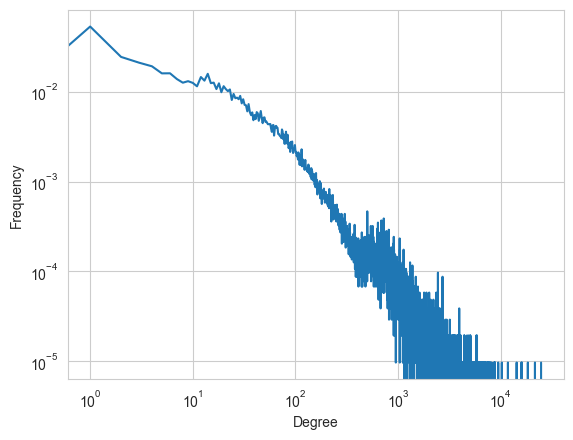

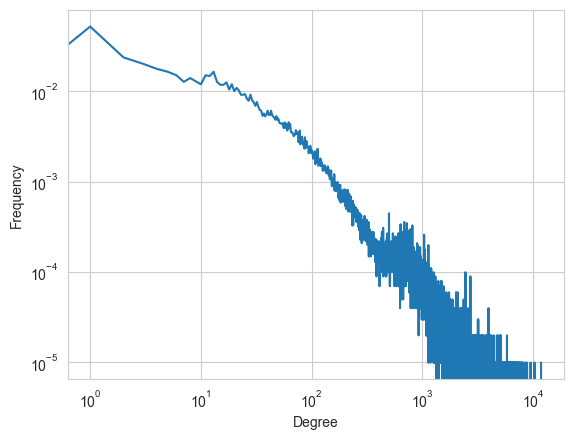

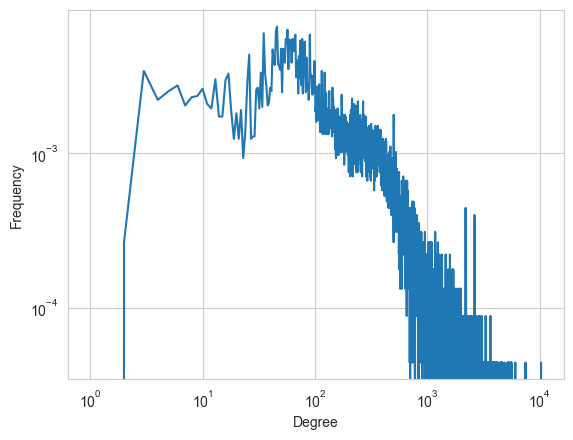

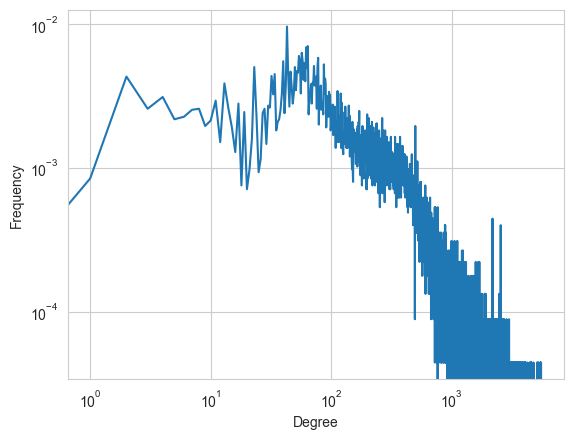

In [55]:
degree_distribution = sparsity['degree_distribution']
degree_distribution = [e / sparsity['nnodes'] for e in degree_distribution]

dd_we = sparsity_we['degree_distribution']
dd_we = [e / sparsity_we['nnodes'] for e in dd_we]

dd_pruned = sparsity_pruned['degree_distribution']
dd_pruned = [e / sparsity_pruned['nnodes'] for e in dd_pruned]

dd_pruned_we = sparsity_pruned_we['degree_distribution']
dd_pruned_we = [e / sparsity_pruned_we['nnodes'] for e in dd_pruned_we]

from matplotlib import pyplot as plt

def plot_degree_distribution(degree_distribution, title='Degree distribution'):
    plt.plot(degree_distribution)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

plot_degree_distribution(degree_distribution, 'Degree distribution')
plot_degree_distribution(dd_we, 'Degree distribution without errors nodes')
plot_degree_distribution(dd_pruned, 'Pruned degree distribution')
plot_degree_distribution(dd_pruned_we, 'Pruned degree distribution without errors nodes')